In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import glob
import scipy as sp
import scipy.sparse.linalg

### Part 2.0.1 Get Mask

source_position:  (189, 107)
Selected region dimensions:
Height: 267
Width: 192


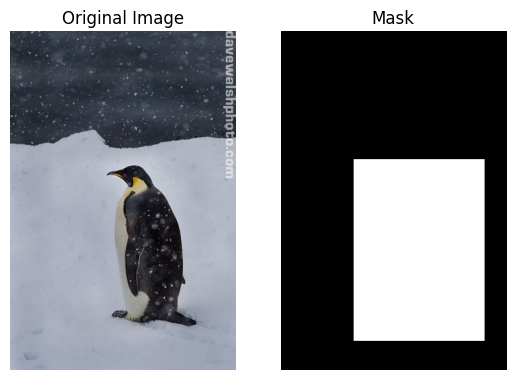

In [2]:
# Define global variables
drawing = False
ix, iy = -1, -1
rect_start = (-1, -1)

img_path = "samples/penguin.jpg"
save_path = "samples/new_mask.jpg"

# Callback function
def draw_rectangle(event, x, y, flags, param):
    global ix, iy, drawing, rect_start, image_copy

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        ix, iy = x, y
        rect_start = (x, y)

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        cv2.rectangle(mask, rect_start, (x, y), (255), -1)

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            image_copy = np.copy(image)
            cv2.rectangle(image_copy, rect_start, (x, y), (0, 0, 255), 2)

# Read the image
image = cv2.imread(img_path)
image_copy = np.copy(image)
mask = np.zeros(image.shape[:2], dtype=np.uint8)

# Create a window and bind the callback function
cv2.namedWindow("Image")
cv2.setMouseCallback("Image", draw_rectangle)

while True:
    cv2.imshow("Image", image_copy)

    # Press "Esc" key to break the loop
    if cv2.waitKey(1) == 27:
        break

cv2.destroyAllWindows()

# Calculate selected region height and width
selected_region = np.where(mask == 255)
min_y, max_y = np.min(selected_region[0]), np.max(selected_region[0])
min_x, max_x = np.min(selected_region[1]), np.max(selected_region[1])
height = max_y - min_y
width = max_x - min_x

soure_position = (min_y,min_x)
print("source_position: ", soure_position)
print("Selected region dimensions:")
print(f"Height: {height}")
print(f"Width: {width}")

# Display the original image and the mask using plt
fig, axes = plt.subplots(1, 2)
axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original Image")
axes[0].axis("off")
axes[1].imshow(mask, cmap="gray")
axes[1].set_title("Mask")
axes[1].axis("off")
plt.show()

### Part 2.0.2 Get Target Position

Selected target positions:
area 1: 
 (1593,593) --> (1860,785)
area 2: 
 (1598,862) --> (1865,1054)
area 3: 
 (1601,1134) --> (1868,1326)
area 4: 
 (1609,1394) --> (1876,1586)


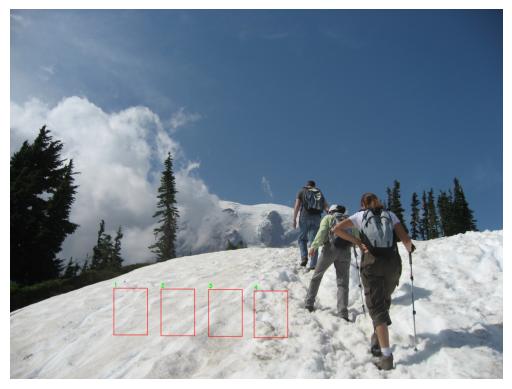

In [3]:
import cv2
import matplotlib.pyplot as plt

# Callback function
def mouse_callback(event, x, y, flags, param):
    # Left mouse button pressed
    if event == cv2.EVENT_LBUTTONDOWN:
        # Record point coordinates
        points.append((x, y))

        # Draw rectangle on the image
        if len(points) >= 1:
            rect_start = points[-1]
            cv2.rectangle(image, rect_start, (rect_start[0] + width, rect_start[1] + height), (0, 0, 255), 2)

        # Draw marker number
        for i, point in enumerate(points):
            cv2.putText(image, str(i + 1), (point[0], point[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)

        # Display the updated image with rectangles and markers
        cv2.imshow("Image", image)

# Read the image
image = cv2.imread("samples/im3.jpg")

# Create a window and resize it to fit the screen
cv2.namedWindow("Image", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Image", 1440, 810)

# Store point coordinates
points = []

# Set mouse callback function
cv2.setMouseCallback("Image", mouse_callback)

# Display the image
cv2.imshow("Image", image)

# Wait for 'q' key to exit
while True:
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break

# Close the window
cv2.destroyAllWindows()

rc_points = []
print("Selected target positions:")
for i,pt in enumerate(points):
    y, x = pt
    rc_points.append((x,y))
    print(f"area {i+1}: \n ({x},{y}) --> ({x+height},{y+width})")
    
points = rc_points

# Display the image with rectangles using plt
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis("off")
plt.show()

### Info we got:
#### 1: img_s and its mask with shape of mask (height, width) <br>
#### 2：source positions in img_s (left top corner)
#### 3: target positions in img_t (left top corner)
#### 4: shift = target_pos - source_pos 

In [4]:
shifts = []
for pt in points:
    x, y = pt
    shift = (x-soure_position[0], y-soure_position[1])
    shifts.append(shift)

In [5]:
print(f"shape: ({height},{width})")
print(f"source positions: {soure_position}")
print(f"target positions: {points}")
print(f"shifts: {shifts}")

shape: (267,192)
source positions: (189, 107)
target positions: [(1593, 593), (1598, 862), (1601, 1134), (1609, 1394)]
shifts: [(1404, 486), (1409, 755), (1412, 1027), (1420, 1287)]


### Some Tools

In [30]:
def get_neighbors(i, j, shape, mode = 'four'):
    """_summary_

    Args:
        i (int): the i-th pixel in source image
        j (int): the j-th pixel in source image
        shape (tuple(height,width)): shape of source image
        mode (str) : four --> get 4 neighbors ; eight --> get 8 neighbors
    """
    
    height, width = shape
    neighbors = []
    
    if(mode == 'four'):
        for index in [-1,+1]:
            if i+index < height and i+index >= 0:
                neighbors.append((i+index, j))
            if j+index < width and j+index >= 0:
                neighbors.append((i, j+index))
    elif(mode == 'eight'):
        for index1 in [-1,+1]:
            for index2 in [-1,+1]:
                if i+index1 < height and i+index1 >= 0 \
                    and j + index2 < width and j + index2 >= 0:
                        neighbors.append((i+index1, j+index2))
    else:
        raise ValueError(f"mode should be four or eight, but got{mode}")
    
    return neighbors

def load_img(path, mode = 'color', normalize = True):
    """_summary_

    Args:
        path (str): path of image
        normalize (bool, optional): scale pixel value to (0,1). Defaults to True.
    """
    
    if not os.path.exists(path):
        raise ValueError(f"wrong image path {path}")
    
    if(mode == 'color'):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif(mode == 'gray'):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    else:
        raise ValueError
    
    if normalize:
        scale_img = img / 255.0
    else:
        scale_img = img
        
    return scale_img

def load_mask(path, threshold = 127):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    # set pixel>threshold to 255 , otherwise 0
    _, binary_mask = cv2.threshold(mask, threshold, 1, cv2.THRESH_BINARY)
    return binary_mask

def show_results(imgs, names):
    fig = plt.figure(figsize=(15,10))
    
    assert(len(imgs) == len(names))
    length = len(imgs)
    
    for i in range(length):
        ax = fig.add_subplot(1, length, i+1)
        if(len(imgs[i].shape) == 2):
            ax.imshow(imgs[i], cmap='gray')
        else:
            ax.imshow(imgs[i])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(names[i])
        
    plt.show()

### Part 2.1 Toy Problem

In [2]:
def reconstruct_img(img):
    # here we just want to reconstruct a gray image
    height, width = img.shape
    num_pixel = height * width
    
    # map each pixel(except for 0) in img to 1:num_pixel
    index_mask = np.zeros(img.shape, dtype='int32')
    index_mask[:, :] = np.arange(0, num_pixel).reshape(height, width)
    
    A_shape = (2 * num_pixel - 1, num_pixel)
    b_shape = 2 * num_pixel - 1
    A = sp.sparse.lil_matrix(A_shape)
    b = np.zeros(b_shape)
    
    rows = np.arange(height).reshape(-1, 1)
    rows = np.tile(rows, (1, width)).flatten()

    cols = np.arange(width).reshape(1, -1)
    cols = np.tile(cols, (height, 1)).flatten()

    row_index = 0
    for i in range(1, num_pixel):
        x, y = rows[i], cols[i]
        
        # A(e, im2var(x,y+1))=1;
        # A(e, im2var(x,y))=-1;
        # b(e) = s(x,y+1)-s(x,y);
        # e=e+1;
        
        if(y == width-1):
            #print(row_index, ", ", index_mask[x][y])
            A[row_index, index_mask[x][y]] = 1
            b[row_index] = img[x][y]
        else:   
            A[row_index, index_mask[x][y+1]] = 1
            A[row_index, index_mask[x][y]] = -1
            b[row_index] = img[x][y+1] - img[x][y]
        
        row_index += 1
        
        # A(e, im2var(x+1,y))=1;
        # A(e, im2var(x,y))=-1;
        # b(e) = s(x+1,y)-s(x,y);
        # e=e+1;
        
        if(x == height-1):
            #print(row_index, ", ", index_mask[x][y])
            A[row_index, index_mask[x][y]] = 1
            b[row_index] = img[x][y]
        else:
            A[row_index, index_mask[x+1][y]] = 1
            A[row_index, index_mask[x][y]] = -1
            b[row_index] = img[x+1][y] - img[x][y]
        
        row_index += 1
        
    # A(e, im2var(1,1))=1;
    # b(e)=s(1,1);
    A[row_index, index_mask[0][0]] = 1
    b[row_index] = img[0][0]
    
    A = sp.sparse.csr_matrix(A)
    result = sp.sparse.linalg.lsqr(A, b)
    v, istop, itn, r1norm = result[0], result[1], result[2], result[3]
    
    print(f"Solution v: {v.shape}")
    print("Termination status: ", istop)
    print("Number of iterations: ", itn)
    print("Final residual norm: ", r1norm)
    
    result = img.copy()
    
    # replace pixel in img_t with v we got
    for i in range(num_pixel):
        x, y = rows[i], cols[i]
        v_index = index_mask[x][y]
        result[x][y] = v[v_index]
        
    result = np.clip(result, 0, 1)
    return result
    

In [21]:
toy = load_img("samples/toy_problem.png", mode = 'gray', normalize = True)
result = reconstruct_img(toy)

Solution v: (13090,)
Termination status:  1
Number of iterations:  435
Final residual norm:  2.142690811748405e-05


In [10]:
cv2.imshow("result", result)
cv2.waitKey(0)

-1

In [22]:
cv2.imwrite("images/origin1.png", toy*255.0)
cv2.imwrite("images/re1.png", result*255.0)

True

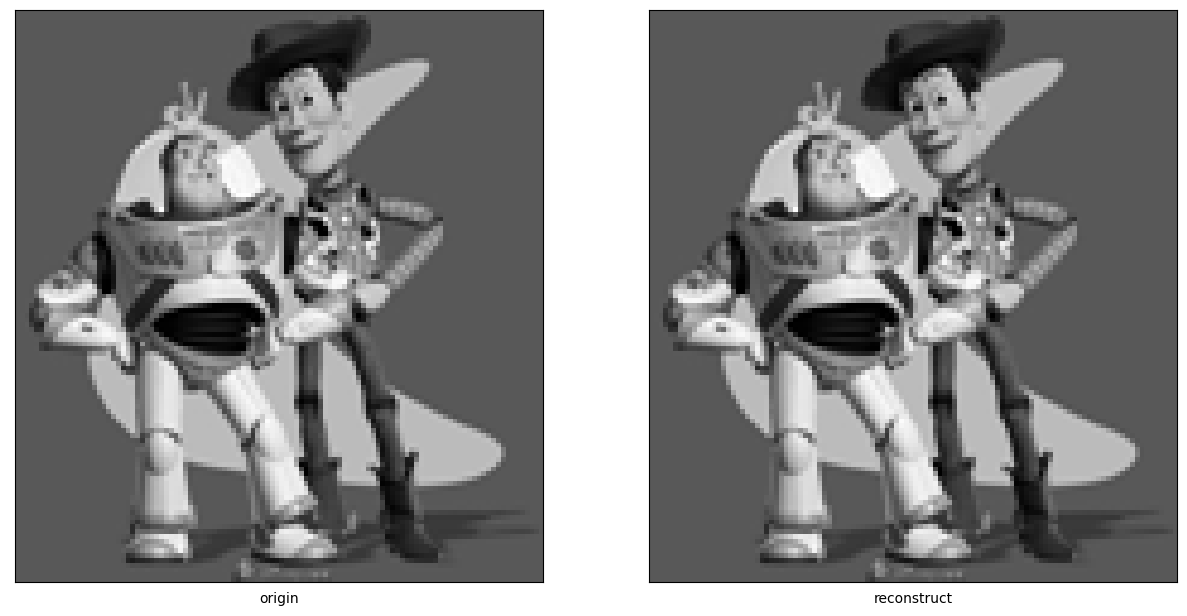

In [31]:
imgs = [toy, result]
names = ["origin", "reconstruct"]
show_results(imgs, names)

### try to reconstruct another image from Set14 dataset:

Solution v: (262144,)
Termination status:  1
Number of iterations:  1312
Final residual norm:  0.0001811768524587081


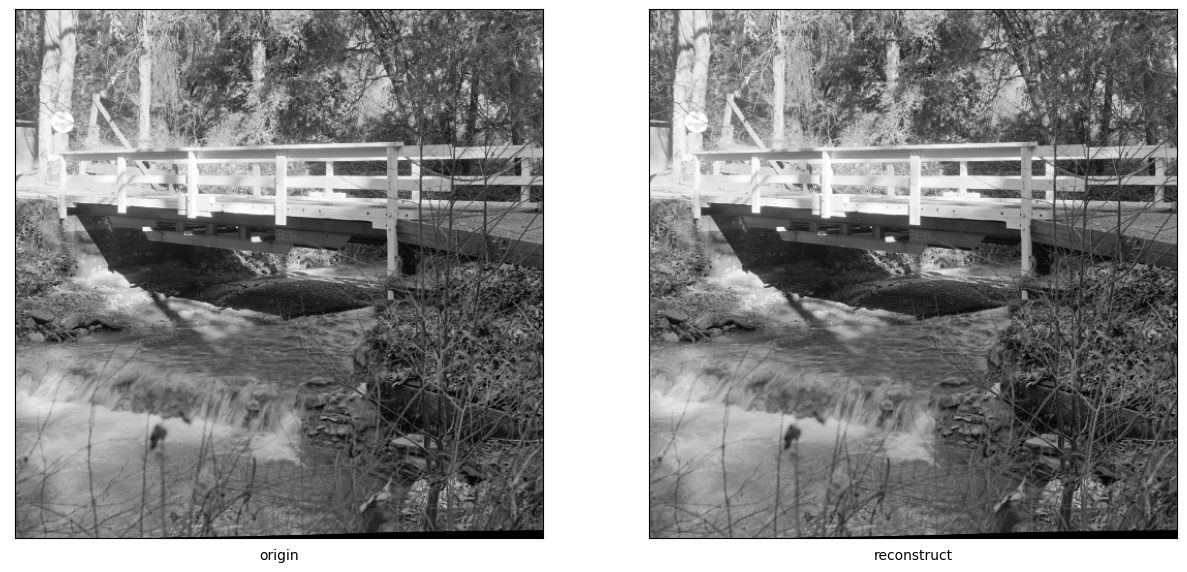

In [32]:
toy1 = load_img("samples/toy_problem_self.png", mode = 'gray', normalize = True)
result1 = reconstruct_img(toy1)
imgs = [toy1, result1]
names = ["origin", "reconstruct"]
show_results(imgs, names)

### Part 2.2 Poisson Blending
$$\min_{v'} \sum_{i\in M,\ j\in N_i\cap M} ((v'_i - v'_j) - (s_i - s_j))^2 + \sum_{i\in M,\ j\in N_i\cap M^c} ((v'_i - t_j) - (s_i - s_j))^2,$$
Here, each "i" is a pixel in the source region "S", and each "j" is a 4-neighbor of "i"

In [11]:
def init_equation(num_pixel):
    """

    We want to create equation:
    A * v = b
    A.shape (4*num_pixel, num_pixel)
    v.shape (num_pixel)
    b.shape (4*num_pixel)
    
    for example:
    
    mask:  m8,m12,m13,m14,m18
    
    index_mask:
           -1,-1,-1,-1,-1
           -1,-1, 0,-1,-1
           -1,+1,+2,+3,-1
           -1,-1,+4,-1,-1
           -1,-1,-1,-1,-1
    
    imgs:  s1,s2,s3,s4,s5
           s6,s7,s8,s9,s10
           s11,s12,s13,s14,s15
           s16,s17,s18,s19,s20
           s21,s22,s23,s24,s25
           
    imgt:  t1, t2, t3, t4, t5
           t6, t7, t8, t9, t10
           t11,t12,t13,t14,t15
           t16,t17,t18,t19,t20
           t21,t22,t23,t24,t25
    
    A:
    
    s8->s3   :| 1, 0, 0, 0, 0|
    s8->s7   :| 1, 0, 0, 0, 0|
    s8->s13  :| 1, 0,-1 ,0, 0| 
    s8->s9   :| 1, 0, 0, 0, 0|
    s12->s7  :| 0, 1, 0, 0, 0|
    s12->s11 :| 0, 1, 0, 0, 0|
    s12->s17 :| 0, 1, 0, 0, 0|
    s12->s13 :| 0, 1,-1, 0, 0|
    s13->s8  :|-1, 0, 1, 0, 0|
    s13->s12 :| 0,-1, 1, 0, 0|
    s13->s18 :| 0, 0, 1, 0,-1|
    s13->s14 :| 0, 0, 1,-1, 0|
    s14->s9  :| 0, 0, 0, 1, 0|
    s14->s13 :| 0, 0,-1, 1, 0|
    s14->s19 :| 0, 0, 0, 1, 0|
    s14->s15 :| 0, 0, 0, 1, 0|
    s18->s13 :| 0, 0,-1, 0, 1|
    s18->s17 :| 0, 0, 0, 0, 1|
    s18->s23 :| 0, 0, 0, 0, 1|
    s18->s19 :| 0, 0, 0, 0, 1|
    
    
    b:
    
    s8->s3   :|(s8-s3) + t3   |
    s8->s7   :|(s8-s7) + t7   |
    s8->s13  :|(s8-s13)       |
    s8->s9   :|(s8-s9) + t9   |
    s12->s7  :|(s12-s7) + t7  |
    s12->s11 :|(s12-s11) + t11|
    s12->s17 :|(s12-s17) + t17|
    s12->s13 :|(s12-s13)      |
    s13->s8  :|(s13-s8)       |
    s13->s12 :|(s13-s12)      |
    s13->s18 :|(s13-s18)      |
    s13->s14 :|(s13-s14)      |
    s14->s9  :|(s14-s9) + t9  |
    s14->s13 :|(s14-s13)      |
    s14->s19 :|(s14-s19) + t19|
    s14->s15 :|(s14-s15) + t15|
    s18->s13 :|(s18-s13)      |
    s18->s17 :|(s18-s17) + t17|
    s18->s23 :|(s18-s23) + t23|
    s18->s19 :|(s18-s19) + t19|
    
    v = |v1, v2, v3, v4, v5|
    
    A * v = b
    
    result:
    
    v1 - v3 = s8 - s13
    v2 - v3 = s12 - s13
    v3 - v1 = s13 - s8
    v3 - v2 = s13 - s12
    v3 - v5 = s13 - s18
    v3 - v4 = s13 - s14
    v5 - v3 = s18 - s13

    """
    
    A_shape = (4 * num_pixel, num_pixel)
    B_shape = 4 * num_pixel
    A = sp.sparse.lil_matrix(A_shape)
    b = np.zeros(B_shape)
    
    return A,b

def solve_equation(A, b):
    A = sp.sparse.csr_matrix(A)
    result = sp.sparse.linalg.lsqr(A, b)
    v, istop, itn, r1norm = result[0], result[1], result[2], result[3]
    
    print(f"Solution v: {v.shape}")
    print("Termination status: ", istop)
    print("Number of iterations: ", itn)
    print("Final residual norm: ", r1norm)
    
    return v


def poisson_blend_channel(img_s, img_t, mask, shifts):
    """_summary_

    Args:
        img_s (np.ndarray): source img (foreground)
        img_t (np.ndarray): target img (background)
        mask (np.ndarray): the mask of img_s (for foreground object)
        shift (x,y) : the shift from img_s to img_t
        
    Here both img_s and img_t are only
    one channel in RGB of original image (R / G / B)
        
    """
    
    # check if there is only one channel
    assert(len(list(img_s.shape)) == 2)
    assert(len(list(img_t.shape)) == 2)
    assert(len(list(mask.shape)) == 2)
    
    height, width = img_s.shape
    
    # num of pixel in mask of foreground
    num_pixel = (mask == 1).sum()
    
    # map each pixel in mask of foreground in range(0, num_pixel)
    # and map each pixel out of foreground to -1
    index_mask = np.zeros(mask.shape, dtype='int32')
    index_mask[mask == 1] = np.arange(num_pixel)
    index_mask[mask == 0] = -1
    
    v_stack = []
    num_of_targets = len(shifts)
    print(f"there are {num_of_targets} targets in total")
    
    for shift in shifts:
    
        A,b = init_equation(num_pixel=num_pixel)
        
        rows, cols = np.where(mask == 1)
        shift_x, shift_y = shift
        
        row_index = 0
        for i in range(num_pixel):
            x, y = rows[i], cols[i]
            
            s_neighbors = get_neighbors(x, y, img_s.shape, "four")
            t_neighbors = get_neighbors(x+shift_x, y+shift_y, img_t.shape, "four")
            assert(len(s_neighbors) == len(t_neighbors))
            # neighbors are tuple list
            # [(x1,y1),(x2,y2),(x3,y3),(x4,y4)]
            for i in range(len(s_neighbors)):
                n_x_s, n_y_s = s_neighbors[i]
                n_x_t, n_y_t = t_neighbors[i]
                # set value in diagonal to 1
                A[row_index, index_mask[x][y]] = 1
                # b[row_index] = Si - Sj
                b[row_index] = img_s[x][y] - img_s[n_x_s][n_y_s]
                
                if(index_mask[n_x_s][n_y_s] == -1):
                    # neighbor is out of foreground
                    b[row_index] += img_t[n_x_t][n_y_t]
                else:
                    A[row_index, index_mask[n_x_s][n_y_s]] = -1
                    
                row_index += 1
            
        v = solve_equation(A, b)
        v_stack.append(v)
    
    
    assert(len(v_stack) == len(shifts))
    result = img_t.copy()
    
    # replace pixel in img_t with v we got
    for i in range(len(shifts)):
        v = v_stack[i]
        shift = shifts[i]
        shift_x, shift_y = shift
        
        for i in range(num_pixel):
            x, y = rows[i], cols[i]
            v_index = index_mask[x][y]
            x_t, y_t = x + shift_x, y + shift_y
            result[x_t][y_t] = v[v_index]
        
    result = np.clip(result, 0, 1)
    
    return result

def poisson_blend(img_s, img_t, mask, shifts):
    """_summary_

    Args:
        img_s (np.ndarray): source img (foreground)
        img_t (np.ndarray): target img (background)
        mask (np.ndarray): the mask of img_s (for foreground object)
        
    Here both img_s and img_t are RGB images
    
    """
    
    shape = img_t.shape
    blend_result = np.zeros(shape)
    channels = 3
    for i in range(channels):
        img_s_ch = img_s[:,:,i]
        img_t_ch = img_t[:,:,i].copy()
        blend_result[:,:,i] = poisson_blend_channel(img_s_ch, img_t_ch, mask, shifts)
        
    return blend_result
    
    

In [12]:
img_s = load_img("samples/penguin.jpg", mode="color", normalize=True)
img_t = load_img("samples/im3.jpg", mode="color", normalize=True)
mask = load_mask("samples/new_mask.jpg")

poisson_result = poisson_blend(img_s, img_t, mask, shifts)

there are 4 targets in total
Solution v: (46517,)
Termination status:  2
Number of iterations:  719
Final residual norm:  0.5852578720719476
Solution v: (46517,)
Termination status:  2
Number of iterations:  725
Final residual norm:  0.43300405941959785
Solution v: (46517,)
Termination status:  2
Number of iterations:  723
Final residual norm:  0.5143289154023686
Solution v: (46517,)
Termination status:  2
Number of iterations:  708
Final residual norm:  0.8756942969693273
there are 4 targets in total
Solution v: (46517,)
Termination status:  2
Number of iterations:  721
Final residual norm:  0.5435832692993257
Solution v: (46517,)
Termination status:  2
Number of iterations:  725
Final residual norm:  0.43546453384640343
Solution v: (46517,)
Termination status:  2
Number of iterations:  724
Final residual norm:  0.5107781410752982
Solution v: (46517,)
Termination status:  2
Number of iterations:  709
Final residual norm:  0.8663268198290243
there are 4 targets in total
Solution v: (46

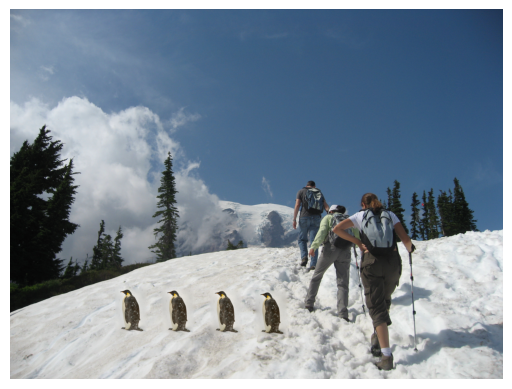

In [13]:
plt.imshow(poisson_result)
plt.axis('off')
plt.show()

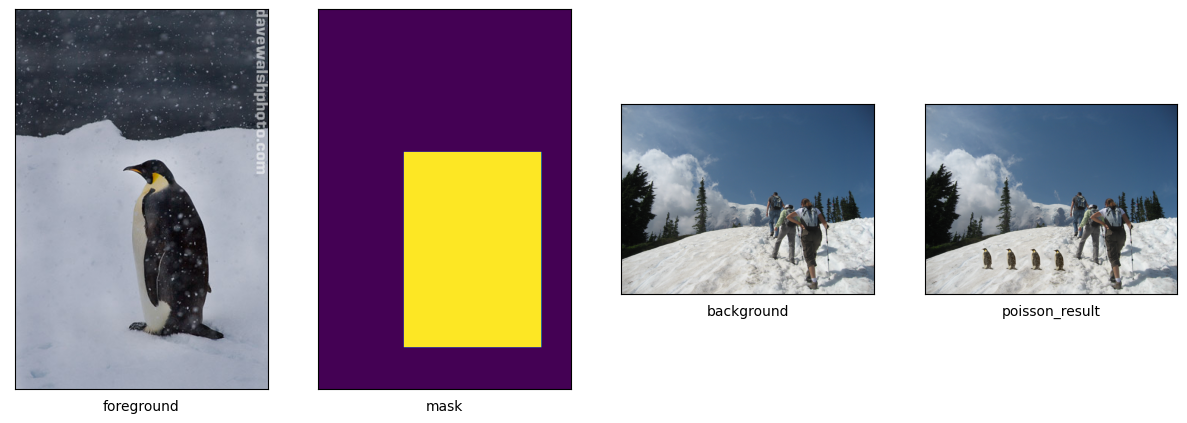

In [14]:
imgs = [img_s, mask, img_t, poisson_result]
names = ["foreground", "mask", "background", "poisson_result"]

show_results(imgs, names)

### Bells & Whistles: Mixed Gradients

$$\min_{v'} \sum_{i\in M,\ j\in N_i\cap M} ((v'_i - v'_j) - g_{ij})^2 + \sum_{i\in M,\ j\in N_i\cap M^c} ((v'_i - t_j) - g_{ij})^2$$

In [25]:
def mixed_gradient_channel(img_s, img_t, mask, shifts):
    """_summary_

    Args:
        img_s (np.ndarray): source img (foreground)
        img_t (np.ndarray): target img (background)
        mask (np.ndarray): the mask of img_s (for foreground object)
        
    Here both img_s and img_t are only
    one channel in RGB of original image (R / G / B)
        
    """
    
    # check if there is only one channel
    assert(len(list(img_s.shape)) == 2)
    assert(len(list(img_t.shape)) == 2)
    assert(len(list(mask.shape)) == 2)
    
    height, width = img_s.shape
    
    # num of pixel in mask of foreground
    num_pixel = (mask == 1).sum()
    
    # map each pixel in mask of foreground in range(0, num_pixel)
    # and map each pixel out of foreground to -1
    index_mask = np.zeros(mask.shape, dtype='int32')
    index_mask[mask == 1] = np.arange(num_pixel)
    index_mask[mask == 0] = -1
    
    v_stack = []
    num_of_targets = len(shifts)
    print(f"there are {num_of_targets} targets in total")
    
    for shift in shifts:
    
        A,b = init_equation(num_pixel=num_pixel)
        
        rows, cols = np.where(mask == 1)
        shift_x, shift_y = shift
        
        row_index = 0
        for i in range(num_pixel):
            x, y = rows[i], cols[i]
            
            s_neighbors = get_neighbors(x, y, img_s.shape, "four")
            t_neighbors = get_neighbors(x+shift_x, y+shift_y, img_t.shape, "four")
            assert(len(s_neighbors) == len(t_neighbors))
            # neighbors are tuple list
            # [(x1,y1),(x2,y2),(x3,y3),(x4,y4)]
            for i in range(len(s_neighbors)):
                n_x_s, n_y_s = s_neighbors[i]
                n_x_t, n_y_t = t_neighbors[i]  
                # set value in diagonal to 1
                A[row_index, index_mask[x][y]] = 1 
                # b[row_index] = max(|Si - Sj|, |Ti - Tj|)
                ds = abs(img_s[x][y] - img_s[n_x_s][n_y_s])
                dt = abs(img_t[x+shift_x][y+shift_y] - img_t[n_x_t][n_y_t])
                
                if(ds > dt):
                    b[row_index] = img_s[x][y] - img_s[n_x_s][n_y_s]
                else:
                    b[row_index] = img_t[x+shift_x][y+shift_y] - img_t[n_x_t][n_y_t]
                
                if(index_mask[n_x_s][n_y_s] == -1):
                    # neighbor is out of foreground
                    b[row_index] += img_t[n_x_t][n_y_t]
                else:
                    A[row_index, index_mask[n_x_s][n_y_s]] = -1
                    
                row_index += 1
                
        v = solve_equation(A, b)
        v_stack.append(v)
    
    assert(len(v_stack) == len(shifts))
    result = img_t.copy()
    
    # replace pixel in img_t with v we got
    for i in range(len(shifts)):
        v = v_stack[i]
        shift = shifts[i]
        shift_x, shift_y = shift
        
        for i in range(num_pixel):
            x, y = rows[i], cols[i]
            v_index = index_mask[x][y]
            x_t, y_t = x + shift_x, y + shift_y
            result[x_t][y_t] = v[v_index]
        
    result = np.clip(result, 0, 1)
    
    return result

def mixed_blend(img_s, img_t, mask, shifts):
    """_summary_

    Args:
        img_s (np.ndarray): source img (foreground)
        img_t (np.ndarray): target img (background)
        mask (np.ndarray): the mask of img_s (for foreground object)
        
    Here both img_s and img_t are RGB images
    
    """
    
    shape = img_t.shape
    blend_result = np.zeros(shape)
    channels = 3
    for i in range(channels):
        img_s_ch = img_s[:,:,i]
        img_t_ch = img_t[:,:,i].copy()
        blend_result[:,:,i] = mixed_gradient_channel(img_s_ch, img_t_ch, mask, shifts)
        
    return blend_result

In [26]:
mixed_result = mixed_blend(img_s, img_t, mask, shifts)

there are 4 targets in total
Solution v: (46517,)
Termination status:  2
Number of iterations:  701
Final residual norm:  1.1962912110793413
Solution v: (46517,)
Termination status:  2
Number of iterations:  697
Final residual norm:  1.2288189812573271
Solution v: (46517,)
Termination status:  2
Number of iterations:  701
Final residual norm:  1.3346636706420572
Solution v: (46517,)
Termination status:  2
Number of iterations:  684
Final residual norm:  1.9207247346029868
there are 4 targets in total
Solution v: (46517,)
Termination status:  2
Number of iterations:  704
Final residual norm:  1.1310823983690237
Solution v: (46517,)
Termination status:  2
Number of iterations:  702
Final residual norm:  1.1601596607939302
Solution v: (46517,)
Termination status:  2
Number of iterations:  704
Final residual norm:  1.2790533256440153
Solution v: (46517,)
Termination status:  2
Number of iterations:  687
Final residual norm:  1.856907614792913
there are 4 targets in total
Solution v: (46517

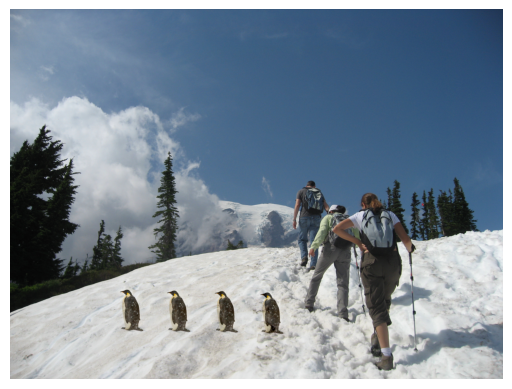

In [27]:
plt.imshow(mixed_result)
plt.axis('off')
plt.show()

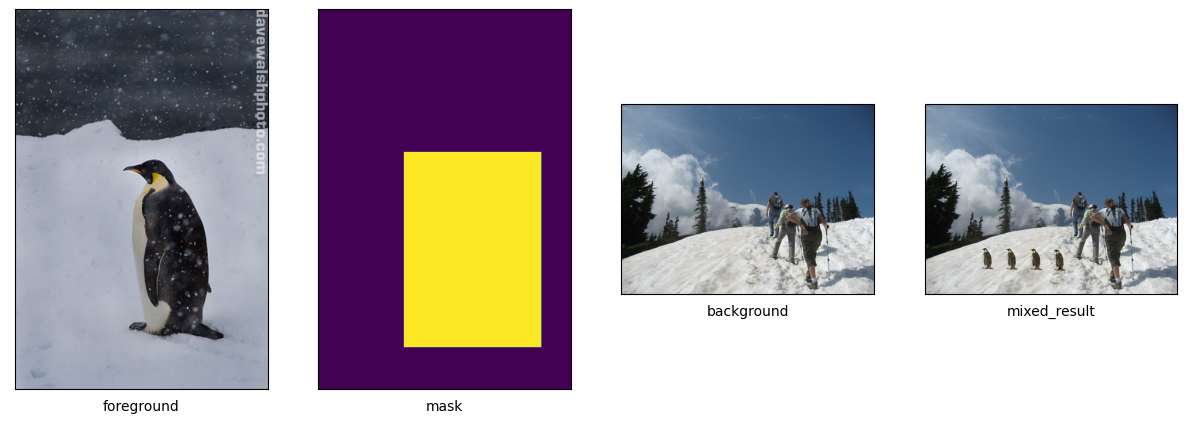

In [29]:
imgs = [img_s, mask, img_t, mixed_result]
names = ["foreground", "mask", "background", "mixed_result"]

show_results(imgs, names)